In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)


In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [3]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=300)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(5))
#take nu% of data as outlier
sampler.fit(training_graphs, nu=0.25, n_jobs=-1)

print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

sampler.save('tmp/sampler.ge')


fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000333852936006, average=False, class_weight=None,
       epsilon=0.1, eta0=0.15653555098, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=66, n_jobs=1,
       penalty='l1', power_t=0.239023823127, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#instances: 300  #interfaces: 122   #cores: 54   #core-interface-pairs: 378
graph grammar stats:
#instances: 300   #interfaces: 122   #cores: 54   #core-interface-pairs: 378
Saved model: tmp/sampler.ge
CPU times: user 14.4 s, sys: 960 ms, total: 15.3 s
Wall time: 31.3 s


In [4]:
%%time
from graphlearn.graphlearn import GraphLearnSampler
sampler=GraphLearnSampler()
sampler.load('tmp/sampler.ge')

# graph sampling
graphs = get_graphs(dataset_fname, size=100)

id_start=34
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
n_steps=50
n_samples=2

from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=True,
                        score_core_choice= False,
                        max_core_size_diff=-1,
                        burnin=1,
                        omit_seed=False,
                        max_cycle_size=0,
                        improving_threshold=.8, 
                        improving_linear_start=0.2,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,
                       estimate_flowback=True)

Loaded model: tmp/sampler.ge
CPU times: user 364 ms, sys: 40 ms, total: 404 ms
Wall time: 408 ms


WARNING you set estimate backflow. the implementation is a little sketchy so dont try this with weired graphs. 
preprocessing grammar
_sample_notes: None
accept_static_penalty: 0.0
batch_size: 10
    burnin: 1
estimate_flowback: True
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000333852936006, average=False, class_weight=None,
       epsilon=0.1, eta0=0.15653555098, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=66, n_jobs=1,
       penalty='l1', power_t=0.239023823127, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimatorwrapper.EstimatorWrapper instance at 0x7fdda156e710>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7fdda156e680>
generator_mode: False
hash_bitmask: 1048575
improving_linear_start: 10
improving_penalty_per_step: 0.0333333333333
improving_threshold: 40
keep_duplicates: True
     

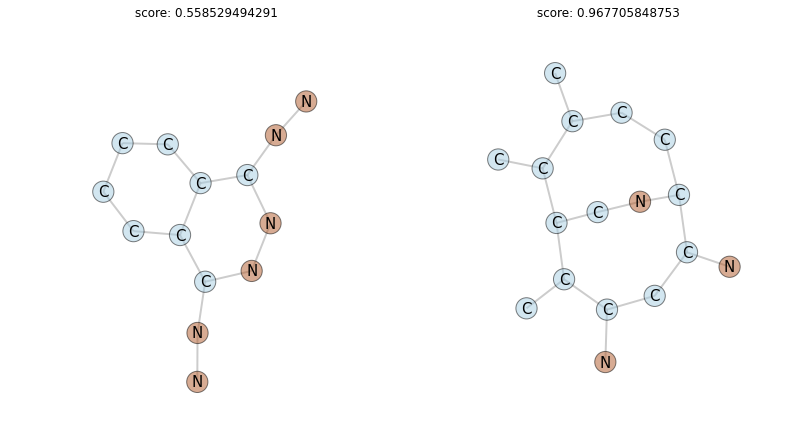

24 19
flow: 1.104314
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
13 13
flow: 0.954545
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0
16 11
flow: 1.136691
_propose_graph: iteration 2 ; core 0 of 7 ; original_cips tried  0
10 8
flow: 1.036952
_propose_graph: iteration 3 ; core 0 of 5 ; original_cips tried  0
3 8
flow: 0.895131
_propose_graph: iteration 4 ; core 0 of 7 ; original_cips tried  0
8 36
flow: 0.983229
_propose_graph: iteration 5 ; core 0 of 14 ; original_cips tried  0
13 13
flow: 1.047619
_propose_graph: iteration 6 ; core 0 of 2 ; original_cips tried  0
13 13
flow: 0.954545
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
13 13
flow: 1.047619
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0
13 13
flow: 0.954545
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0
8 10
flow: 1.005571
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
5 6
flow: 1.053333
_propose_graph: 

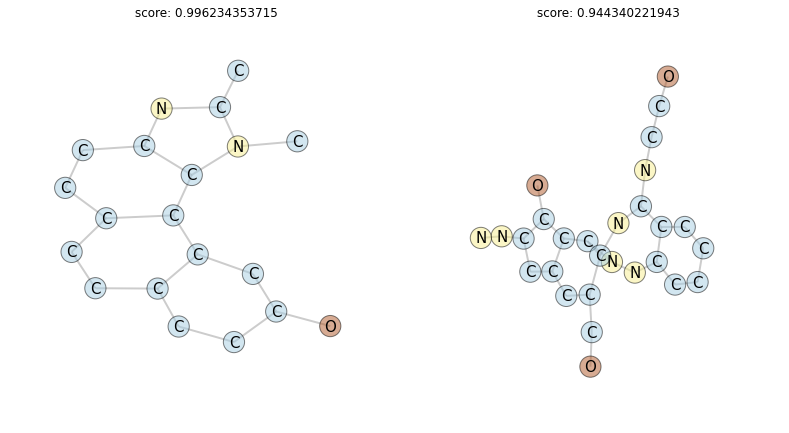

8 21
flow: 0.763200
_propose_graph: iteration 0 ; core 0 of 16 ; original_cips tried  0
22 36
flow: 0.830565
_propose_graph: iteration 1 ; core 0 of 14 ; original_cips tried  0
8 8
flow: 1.111111
_propose_graph: iteration 2 ; core 0 of 4 ; original_cips tried  0
34 37
flow: 1.004983
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0
12 2
flow: 1.028986
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0
48 31
flow: 1.077646
_propose_graph: iteration 5 ; core 0 of 2 ; original_cips tried  0
2 10
flow: 0.970149
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0
31 50
flow: 0.922548
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
12 2
flow: 1.028986
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0
16 8
flow: 1.163934
_propose_graph: iteration 9 ; core 0 of 7 ; original_cips tried  0
8 16
flow: 0.859155
_propose_graph: iteration 10 ; core 0 of 7 ; original_cips tried  0
16 11
flow: 1.278899
_propose_graph: 

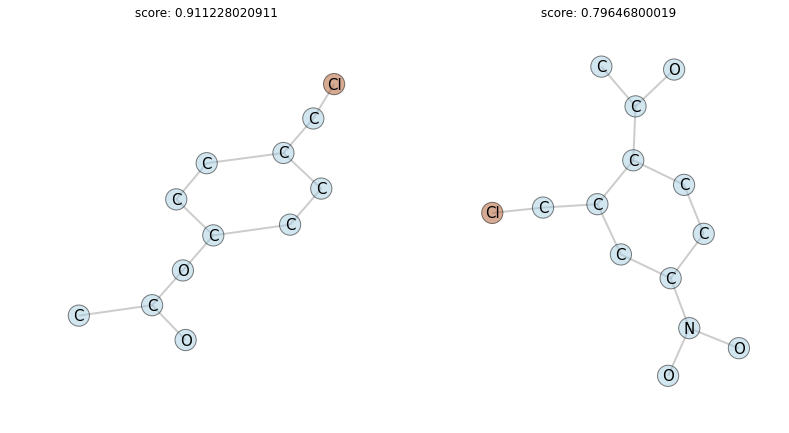

12 10
flow: 0.934066
_propose_graph: iteration 0 ; core 0 of 4 ; original_cips tried  0
62 72
flow: 0.933725
_propose_graph: iteration 1 ; core 0 of 3 ; original_cips tried  0
37 17
flow: 1.119080
_propose_graph: iteration 2 ; core 0 of 7 ; original_cips tried  0
54 29
flow: 1.167102
_propose_graph: iteration 3 ; core 0 of 14 ; original_cips tried  0
29 29
flow: 0.891892
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0
45 17
flow: 1.092575
_propose_graph: iteration 5 ; core 0 of 7 ; original_cips tried  0
32 27
flow: 1.109179
_propose_graph: iteration 6 ; core 0 of 2 ; original_cips tried  0
13 19
flow: 0.961136
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
19 1
flow: 0.952632
_propose_graph: iteration 8 ; core 0 of 7 ; original_cips tried  0
19 19
flow: 1.000000
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0
17 17
flow: 0.897436
_propose_graph: iteration 10 ; core 0 of 7 ; original_cips tried  0
1 32
flow: 1.056881
_propose_gr

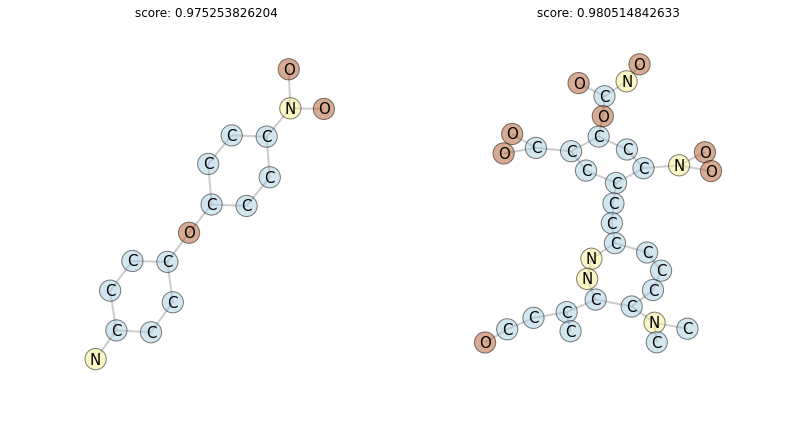

29 11
flow: 1.078580
_propose_graph: iteration 0 ; core 0 of 7 ; original_cips tried  0
15 18
flow: 1.004237
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0
34 64
flow: 0.876693
_propose_graph: iteration 2 ; core 0 of 14 ; original_cips tried  0
11 5
flow: 1.030960
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0
54 36
flow: 1.040816
_propose_graph: iteration 4 ; core 0 of 7 ; original_cips tried  0
57 30
flow: 0.984211
_propose_graph: iteration 5 ; core 0 of 1 ; original_cips tried  1
13 5
flow: 1.026810
_propose_graph: iteration 6 ; core 0 of 2 ; original_cips tried  0
23 22
flow: 1.091942
_propose_graph: iteration 7 ; core 0 of 4 ; original_cips tried  0
22 17
flow: 0.909684
_propose_graph: iteration 8 ; core 0 of 4 ; original_cips tried  0
30 57
flow: 1.015254
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0
7 8
flow: 0.863354
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
36 19
flow: 1.036070
_propose_grap

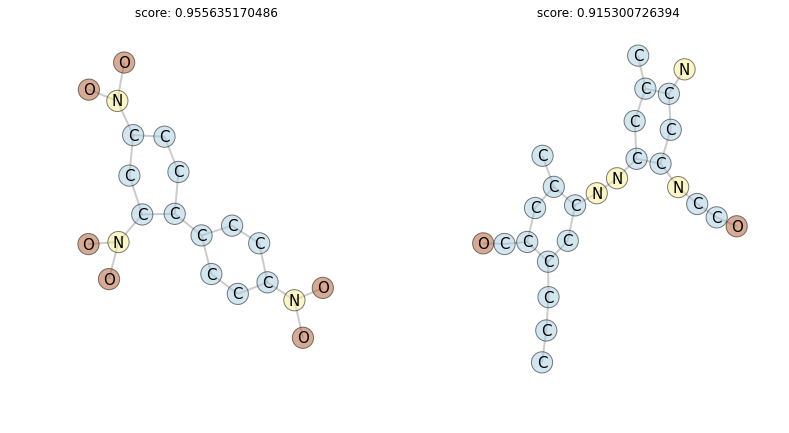

16 35
flow: 0.932632
_propose_graph: iteration 0 ; core 0 of 3 ; original_cips tried  0
43 56
flow: 0.764481
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0
36 24
flow: 1.424242
_propose_graph: iteration 2 ; core 0 of 14 ; original_cips tried  0
66 59
flow: 1.110694
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0
24 18
flow: 1.081081
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0
19 33
flow: 0.759729
_propose_graph: iteration 5 ; core 0 of 14 ; original_cips tried  0
8 8
flow: 1.111111
_propose_graph: iteration 6 ; core 0 of 16 ; original_cips tried  0
18 12
flow: 0.980198
_propose_graph: iteration 7 ; core 0 of 6 ; original_cips tried  0
47 67
flow: 0.683071
_propose_graph: iteration 8 ; core 0 of 7 ; original_cips tried  0
66 48
flow: 1.467532
_propose_graph: iteration 9 ; core 0 of 7 ; original_cips tried  0
21 1
flow: 1.005952
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0
26 23
flow: 1.124661
_propose_g

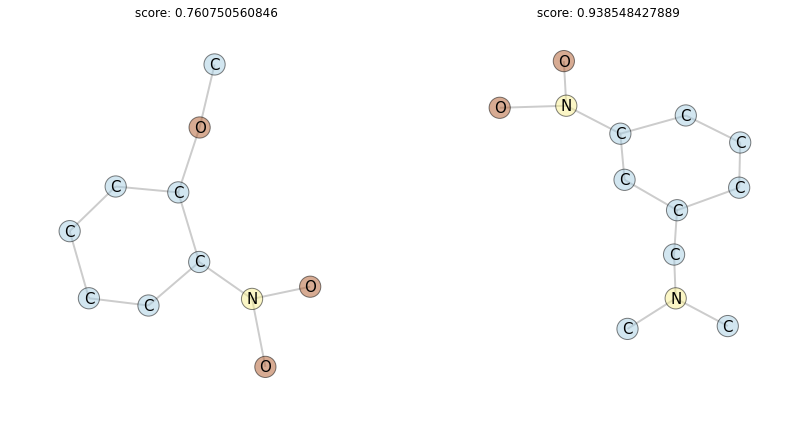

59 52
flow: 1.120820
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
8 44
flow: 1.036145
_propose_graph: iteration 1 ; core 0 of 7 ; original_cips tried  0
10 3
flow: 0.972763
_propose_graph: iteration 2 ; core 0 of 7 ; original_cips tried  0
44 21
flow: 1.185301
_propose_graph: iteration 3 ; core 0 of 7 ; original_cips tried  0
18 8
flow: 0.983766
_propose_graph: iteration 4 ; core 0 of 7 ; original_cips tried  0
21 14
flow: 1.033898
_propose_graph: iteration 5 ; core 0 of 7 ; original_cips tried  0
34 8
flow: 1.015052
_propose_graph: iteration 6 ; core 0 of 14 ; original_cips tried  0
16 6
flow: 1.021201
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
6 9
flow: 1.007299
_propose_graph: iteration 8 ; core 0 of 16 ; original_cips tried  0
3 1
flow: 0.976190
_propose_graph: iteration 9 ; core 0 of 16 ; original_cips tried  0
8 6
flow: 1.032258
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
17 8
flow: 1.131503
_propose_graph: ite

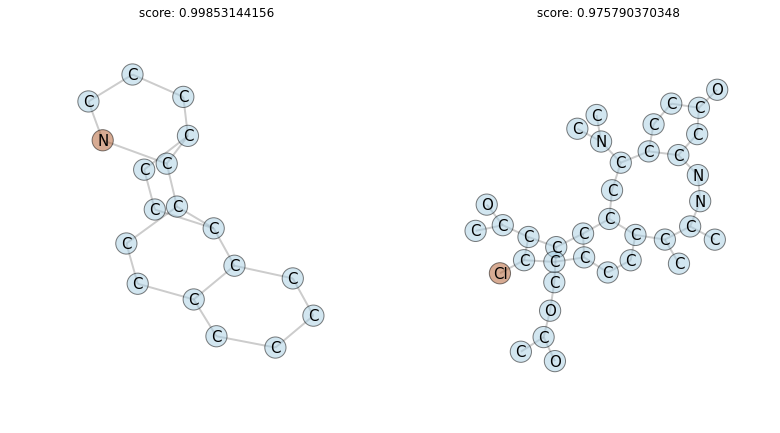

12 12
flow: 1.040816
_propose_graph: iteration 0 ; core 0 of 5 ; original_cips tried  0
19 14
flow: 1.078406
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0
14 35
flow: 0.979058
_propose_graph: iteration 2 ; core 0 of 3 ; original_cips tried  0
13 15
flow: 0.964912
_propose_graph: iteration 3 ; core 0 of 2 ; original_cips tried  0
41 16
flow: 0.981891
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0
24 6
flow: 0.976285
_propose_graph: iteration 5 ; core 0 of 2 ; original_cips tried  0
11 16
flow: 1.007746
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0
34 32
flow: 1.082019
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
24 24
flow: 0.962264
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0
8 38
flow: 1.024917
_propose_graph: iteration 9 ; core 0 of 14 ; original_cips tried  0
15 10
flow: 0.992481
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
22 13
flow: 1.066703
_propose_gr

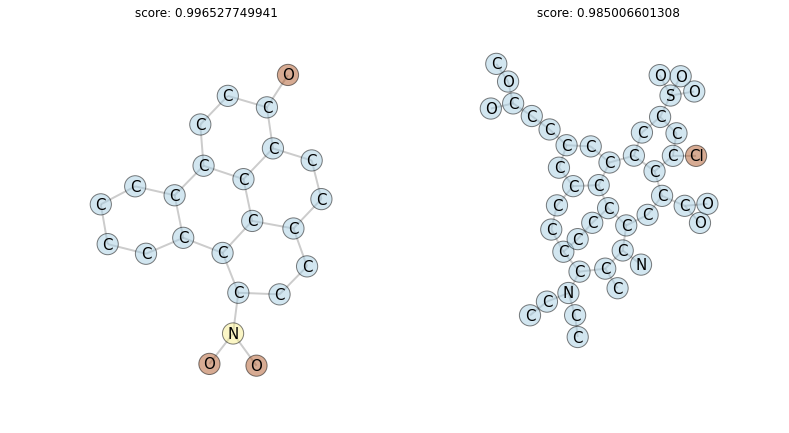

10 10
flow: 1.019231
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
22 36
flow: 0.985654
_propose_graph: iteration 1 ; core 0 of 14 ; original_cips tried  0
16 27
flow: 0.966048
_propose_graph: iteration 2 ; core 0 of 7 ; original_cips tried  0
12 3
flow: 1.048193
_propose_graph: iteration 3 ; core 0 of 7 ; original_cips tried  0
13 13
flow: 1.018868
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0
47 6
flow: 0.985510
_propose_graph: iteration 5 ; core 0 of 5 ; original_cips tried  1
33 36
flow: 1.019696
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0
3 13
flow: 0.993080
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0
11 14
flow: 1.020958
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0
11 2
flow: 1.005610
_propose_graph: iteration 9 ; core 0 of 7 ; original_cips tried  0
3 13
flow: 0.993205
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
20 1
flow: 0.982727
_propose_graph:

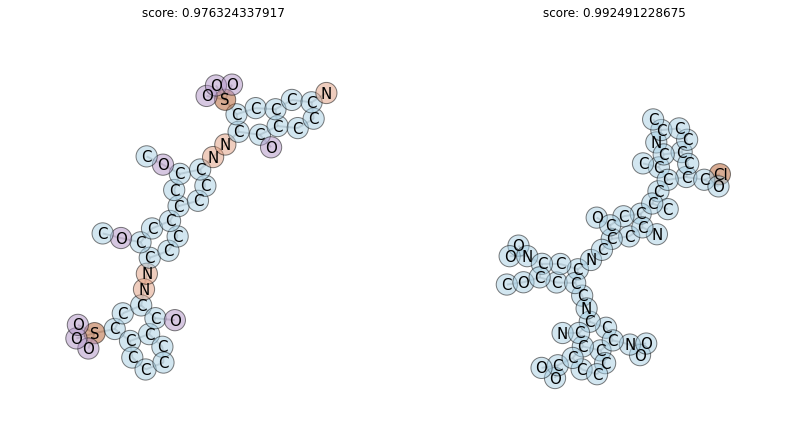

6 16
flow: 0.821656
_propose_graph: iteration 0 ; core 0 of 14 ; original_cips tried  0
12 29
flow: 0.948164
_propose_graph: iteration 1 ; core 0 of 5 ; original_cips tried  0
43 59
flow: 0.814229
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0
16 6
flow: 1.050847
_propose_graph: iteration 3 ; core 0 of 14 ; original_cips tried  0
26 19
flow: 1.083793
_propose_graph: iteration 4 ; core 0 of 7 ; original_cips tried  0
26 21
flow: 1.287831
_propose_graph: iteration 5 ; core 0 of 7 ; original_cips tried  0
43 59
flow: 0.814229
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0
7 7
flow: 1.117647
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0
28 66
flow: 0.923602
_propose_graph: iteration 8 ; core 0 of 7 ; original_cips tried  0
20 16
flow: 1.110345
_propose_graph: iteration 9 ; core 0 of 4 ; original_cips tried  0
32 51
flow: 0.669540
_propose_graph: iteration 10 ; core 0 of 14 ; original_cips tried  0
82 46
flow: 1.334347
_propose_gr

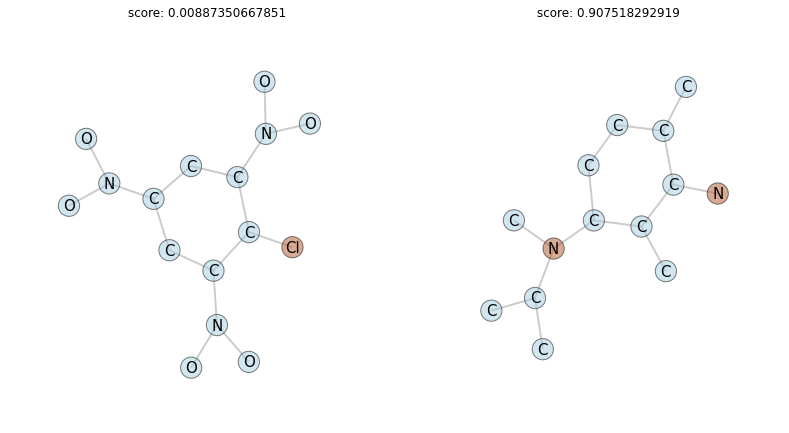

28 41
flow: 0.833691
_propose_graph: iteration 0 ; core 0 of 2 ; original_cips tried  0
46 22
flow: 1.045643
_propose_graph: iteration 1 ; core 0 of 7 ; original_cips tried  0
11 15
flow: 1.080000
_propose_graph: iteration 2 ; core 0 of 2 ; original_cips tried  0
37 38
flow: 1.138914
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0
13 16
flow: 1.005764
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0
47 28
flow: 1.041192
_propose_graph: iteration 5 ; core 0 of 7 ; original_cips tried  0
18 11
flow: 1.144274
_propose_graph: iteration 6 ; core 0 of 7 ; original_cips tried  0
25 25
flow: 1.000000
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0
18 6
flow: 1.022472
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0
2 2
flow: 0.955556
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0
28 20
flow: 1.128302
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0
2 1
flow: 0.980000
_propose_graph:

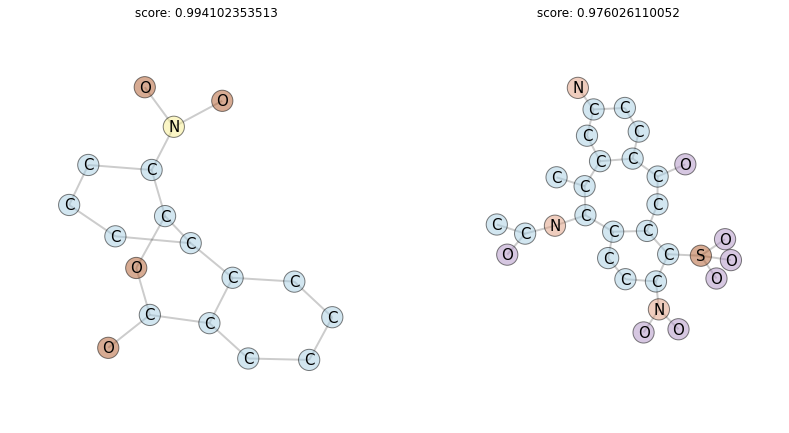

62 40
flow: 1.093381
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0
3 1
flow: 1.013889
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0
28 23
flow: 1.086261
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0
39 8
flow: 1.012929
_propose_graph: iteration 3 ; core 0 of 14 ; original_cips tried  0
41 19
flow: 1.023299
_propose_graph: iteration 4 ; core 0 of 14 ; original_cips tried  0
7 6
flow: 0.997351
_propose_graph: iteration 5 ; core 0 of 9 ; original_cips tried  0
6 1
flow: 1.005952
_propose_graph: iteration 6 ; core 0 of 7 ; original_cips tried  0
1 1
flow: 1.000000
_propose_graph: iteration 7 ; core 0 of 3 ; original_cips tried  0
46 25
flow: 1.059489
_propose_graph: iteration 8 ; core 0 of 7 ; original_cips tried  0
33 40
flow: 0.969815
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0
8 2
flow: 0.979866
_propose_graph: iteration 10 ; core 0 of 7 ; original_cips tried  0
2 3
flow: 1.006579
_propose_graph: itera

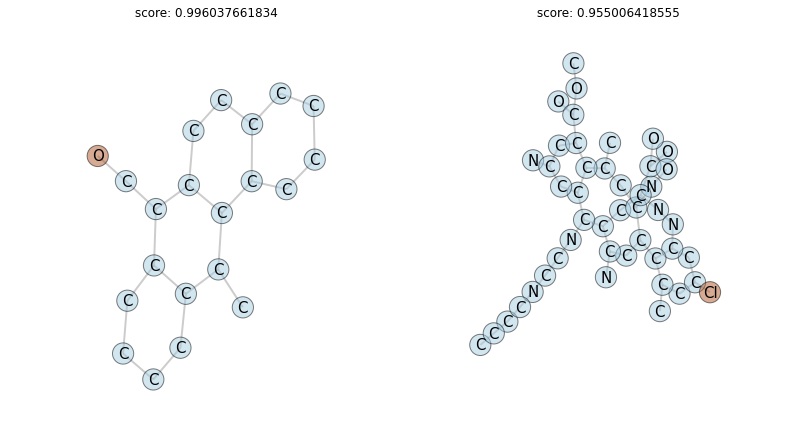

CPU times: user 54 s, sys: 744 ms, total: 54.7 s
Wall time: 55.9 s


In [5]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import  graphlearn_draw, get_score_of_graph
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450,
                   headlinehook=get_score_of_graph)

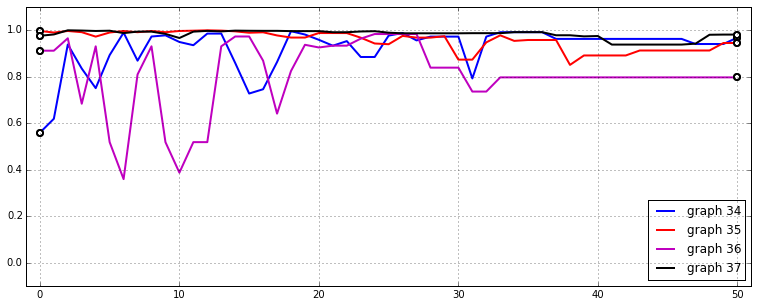

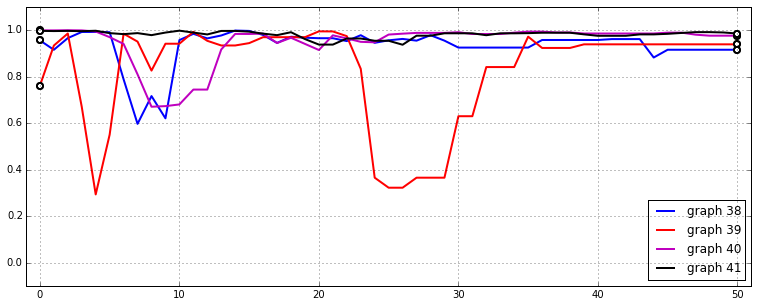

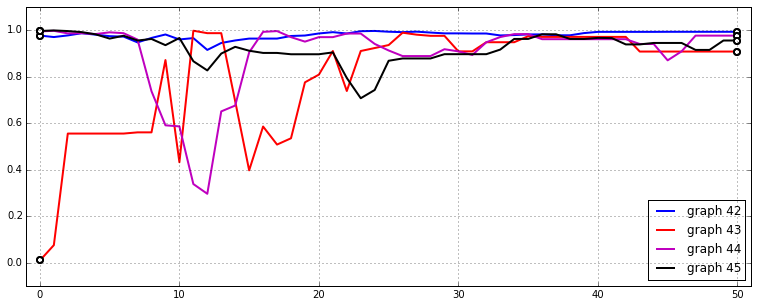

CPU times: user 784 ms, sys: 20 ms, total: 804 ms
Wall time: 801 ms


In [6]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples-1)
step=1
num_graphs_per_plot=4
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

.